<a href="https://colab.research.google.com/github/Auroraleone/MLDLproject-/blob/main/StatsForData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stats for Data

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
ann_data = json.load(open("/content/ego4d_data/v1/annotations/nlq_train.json"))

In [ ]:
# please see https://ego4d-data.org/docs/data/annotations-schemas/

anns = []
for vid in ann_data["videos"]:
    for clip in vid["clips"]:
        for ann in clip["annotations"]:
            for query in ann["language_queries"]:
                anns.append({
                    "query_start_time_sec": clip["video_start_sec"],
                    "query_end_time_sec": clip["video_end_sec"],
                    "query_response_start_time_sec": query["video_start_sec"],
                    "query_response_end_time_sec": query["video_end_sec"],
                    "query_template": query.get("template", None),
                    "query": query.get("query", None),
                })

In [ ]:
num_queries = len(anns)
relative_query_sizes = np.array([
    (a["query_response_end_time_sec"] - a["query_response_start_time_sec"]) / (a["query_end_time_sec"] - a["query_start_time_sec"])
    for a in anns
])
query_sizes = np.array([
    (a["query_response_end_time_sec"] - a["query_response_start_time_sec"])
    for a in anns
])
clip_sizes = np.array([
    (a["query_end_time_sec"] - a["query_start_time_sec"])
    for a in anns
])

## Query / Response Durations

Here we can see that there are some queries with 0s. When training it is reccomended to remove them from the set. For VSLNet you can provide `--remove_empty_queries_from train` to `main.py` (e.g. if you are modifying this codebase).

In [ ]:
query_sizes.max(), query_sizes.min(), query_sizes.std(), query_sizes.mean()

(480.0, 0.0, 22.82781402544118, 9.67047539528926)

In [ ]:
# less than or equal to 4 frames => 9% of training data
(query_sizes <= 4/30).sum() / len(relative_query_sizes)

0.09012039660056657

## Distribution of Queries (relative)

Here is a histogram plot of the relative query size to the clip size.

In [ ]:
plt.rcParams["figure.figsize"] = (16, 9)

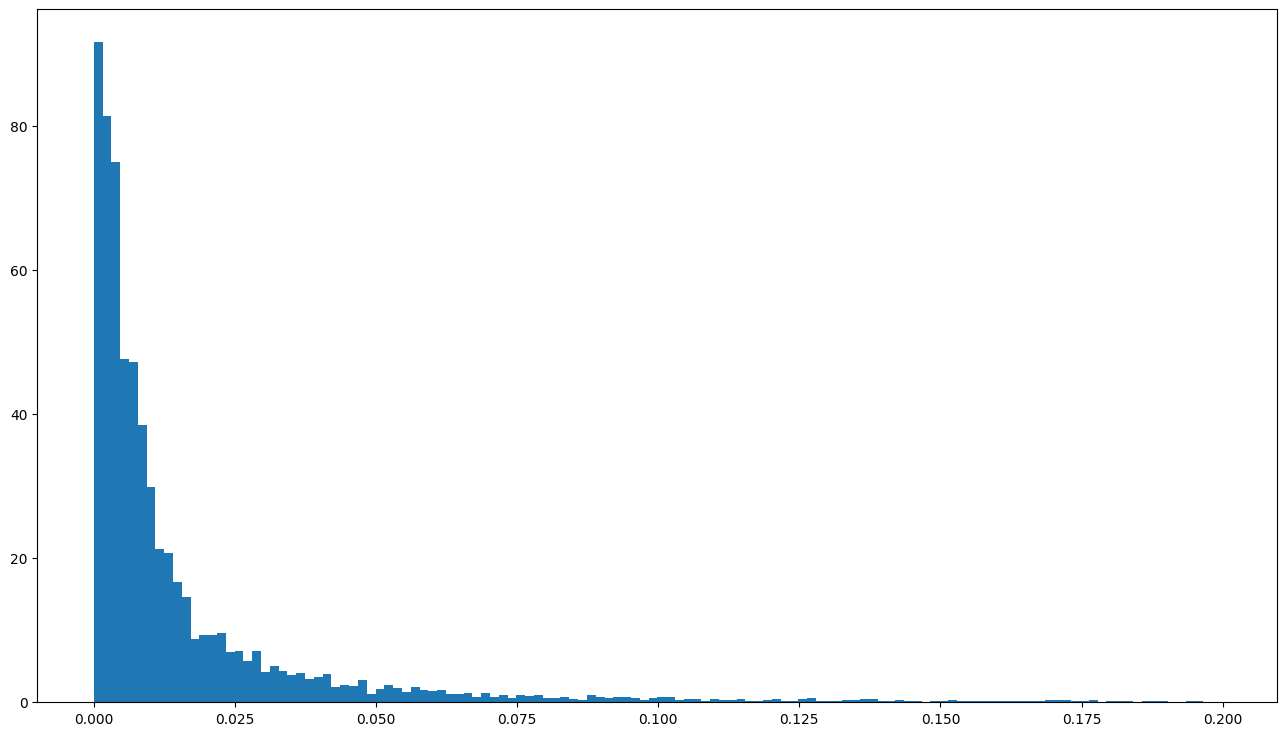

In [ ]:
plt.hist(relative_query_sizes[relative_query_sizes < 0.2], density=True, bins=128)
plt.show()

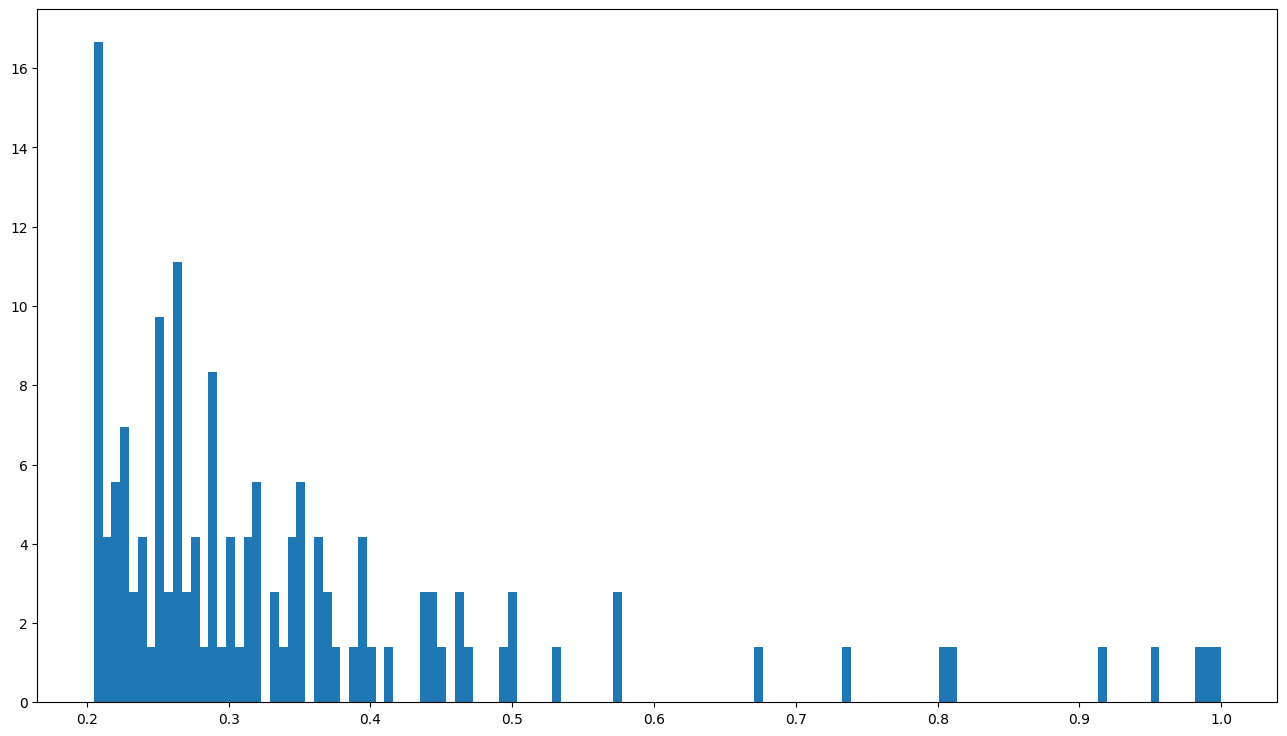

In [ ]:
plt.hist(relative_query_sizes[relative_query_sizes > 0.2], density=True, bins=128)
plt.show()

## Clip Sizes

Clips are 522s on average, with most clips being 480s.

In [ ]:
clip_sizes.mean(), clip_sizes.max(), clip_sizes.min(), clip_sizes.std(), np.median(clip_sizes)

(522.6759852928087,
 1200.0666422526042,
 207.16666666666674,
 197.6377591205408,
 480.0)

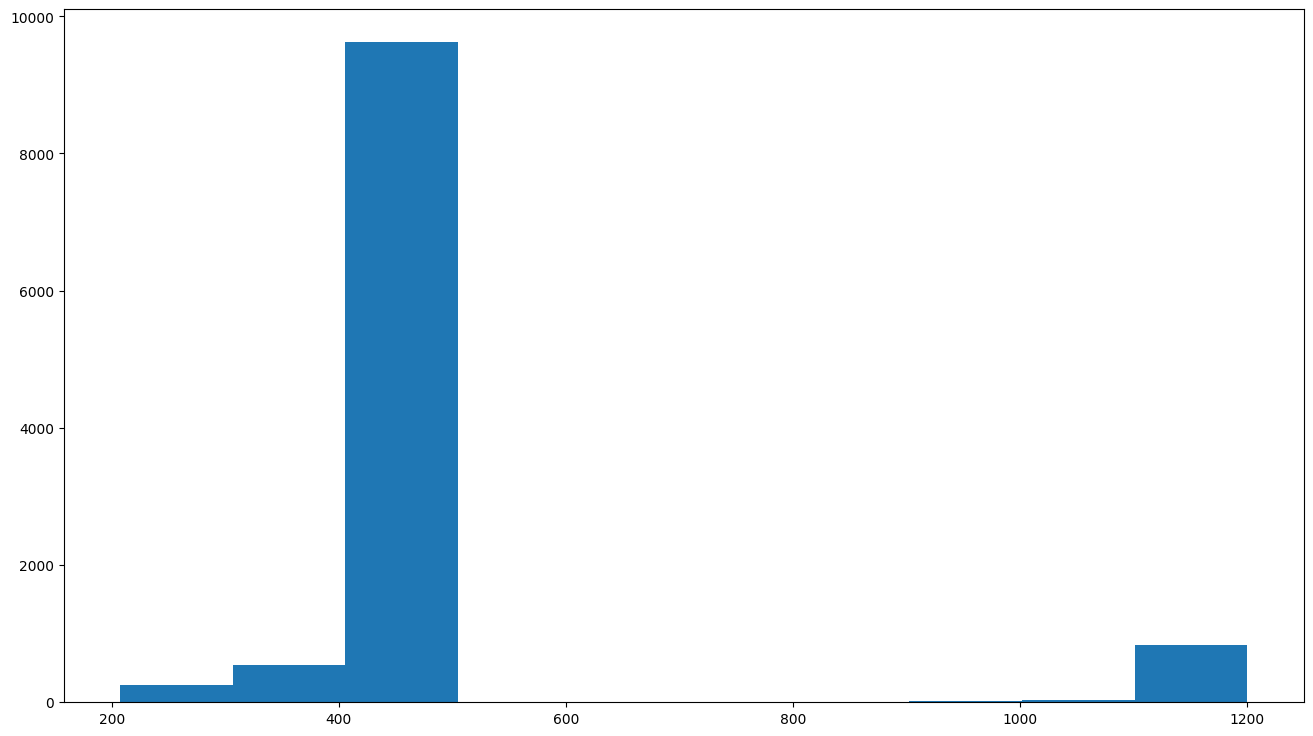

In [ ]:
plt.hist(clip_sizes)
plt.show()

##Our dataset analysis

plotting the queries distribution according to their template, their average duration of the input clips, the distribution of the answer segments along the videos. Additionally, you can use the ego4d.json annotations to get the scenarios, for example cooking or commuting, associated with each video and see how these correlate with the NLQ annotations

###Templates distribution

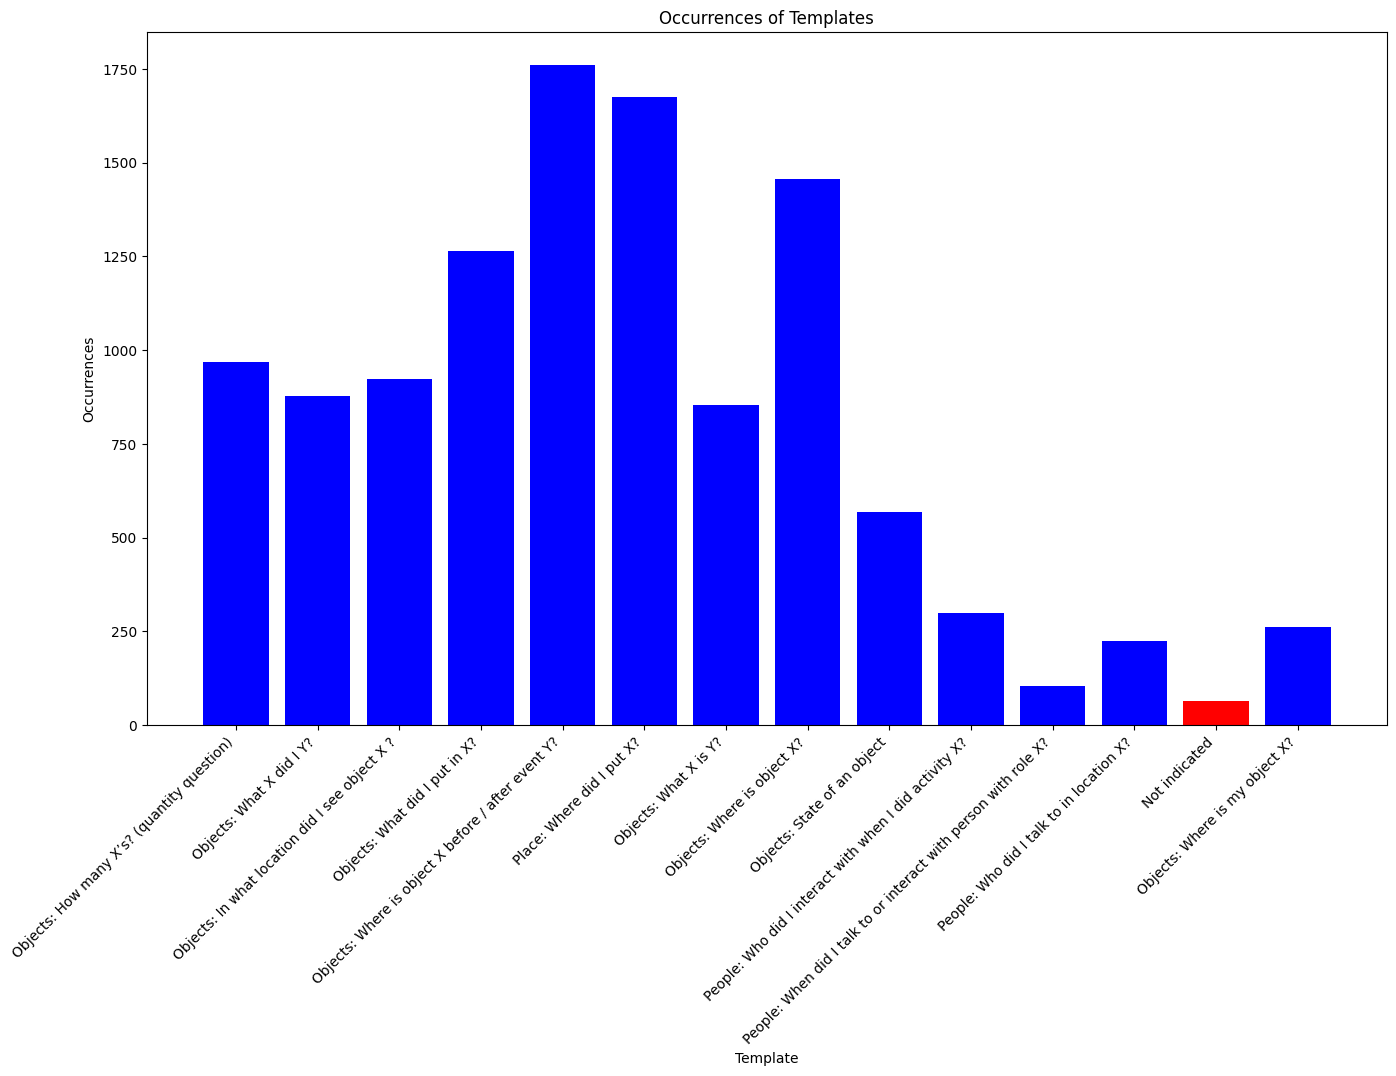

In [ ]:
import pandas as pd
temps = [a["query_template"] for a in anns]

template_count = {}
for template in temps:
    if template == None:
      template = "Not indicated"
    if template in template_count:
        template_count[template] += 1
    else:
        template_count[template] = 1

unique_templates = list(template_count.keys())
counts = list(template_count.values())

colors = ['blue' if template != "Not indicated" else 'red' for template in unique_templates]

plt.bar(unique_templates, counts, color = colors)
plt.xlabel('Template')
plt.ylabel('Occurrences')
plt.title('Occurrences of Templates')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

plt.show()

###Distribution of answer segments

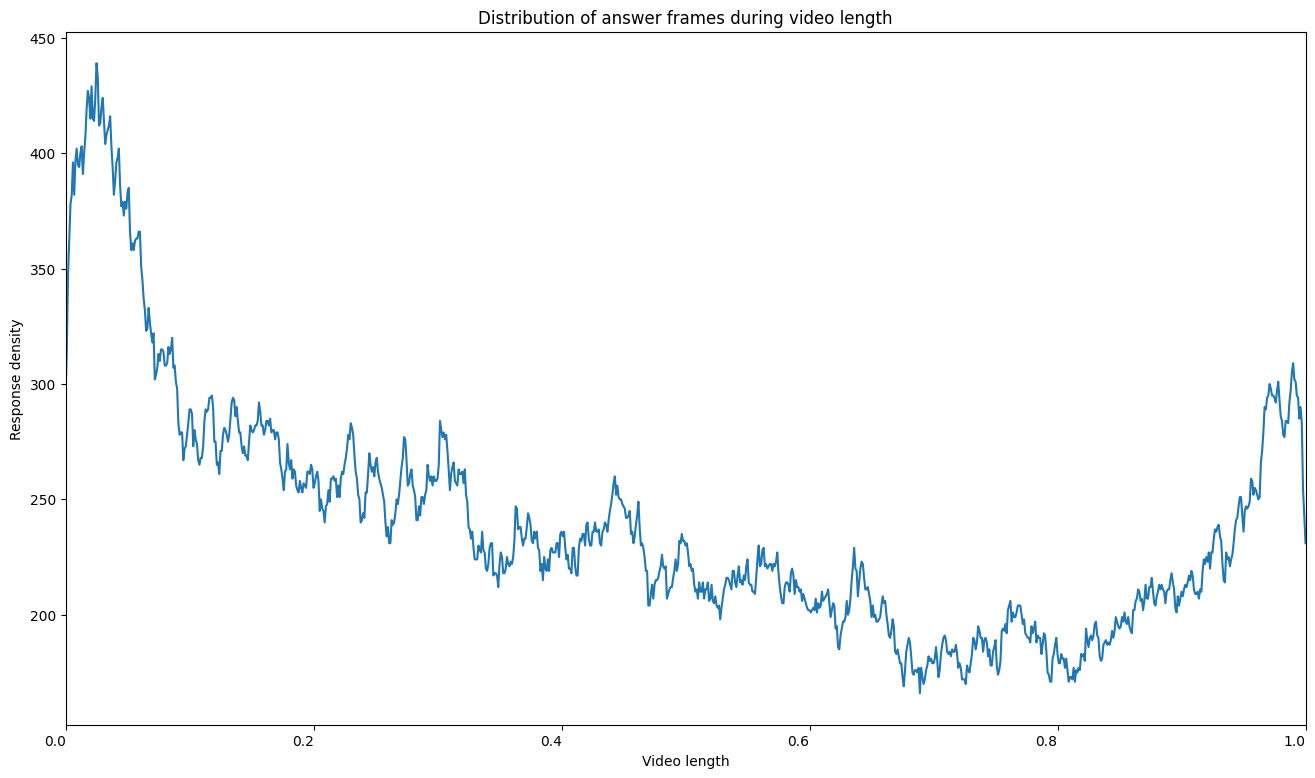

In [ ]:
bins = 1000
digits = 3
frames = {(numer/bins):0 for numer in range(bins+1)}

for annotation in anns:
  relative_start = (annotation["query_response_start_time_sec"] - annotation["query_start_time_sec"]) / (annotation["query_end_time_sec"] - annotation["query_start_time_sec"])
  relative_start = round(relative_start, digits)
  relative_end = (annotation["query_response_end_time_sec"] - annotation["query_start_time_sec"]) / (annotation["query_end_time_sec"] - annotation["query_start_time_sec"])
  relative_end = round(relative_end, digits)
  frame_answer = list(np.arange(start=relative_start, stop = relative_end+(1/bins), step = (1/bins)))
  frame_answer = [round(i, digits) for i in frame_answer]
  for fr in frame_answer:
    try:
      frames[fr] += 1
    except KeyError:
      continue



plt.figure()
plt.plot(frames.keys(), frames.values())
plt.xlabel('Video length')
plt.ylabel('Response density')
plt.title('Distribution of answer frames during video length')

# Rotate x-axis labels
plt.xticks(rotation=0, ha='right')
plt.xlim(0, 1)

plt.show()